In [29]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch import nn
import torch.nn.functional as F
from SproutDataset import SproutDataset
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms import SimSiamTransform
import torch

import matplotlib.pyplot as plt
from lightly.loss import NTXentLoss

BATCH_SIZE = 32

In [3]:
import tqdm
import umap.umap_ as umap
import numpy as np
import hdbscan
import sklearn.metrics as metrics

Self-supervised search: run infidence on the backbone+projection head

Feed the spectra thu the backbone, then backbone to proj head. Give 128 values. Encoding spectra to vector of size 128.
End up with vector for each one of the spectra. 

Take those 128 values for all spectra, and pass them to Umap. Turn 128 values to (x,y) coordinates.

In [26]:
class Siamese1DNet_backbone(nn.Module):
    def __init__(self, output_dim=128):
        super(Siamese1DNet_backbone, self).__init__()
                
        # Shared feature extraction network
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Fully connected layers for embeddings
        self.fc1 = nn.Linear(7168, output_dim)  # keep the backbone complex enough
    
    def forward(self, x):
    # Feature extraction
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) #
        # print('here')
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) 
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))   
        return F.normalize(x, dim=1)

In [27]:
dataset_path = "C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train_mini.nc"
datasetsingle = SproutDataset(dataset_path=dataset_path, augmentation_type='single')
dataloader = DataLoader(
            datasetsingle,
            batch_size=BATCH_SIZE,
            shuffle=True)

In [37]:
class SimSiam(pl.LightningModule):
    def __init__(self, output_dim=2, backbone_output_dim=128, hidden_layer_dim=64):
        super().__init__()
        self.backbone = Siamese1DNet_backbone(output_dim=backbone_output_dim)

        # projection head: map data representations into a space that facilitates comparison and learning
        self.projection_head = SimSiamProjectionHead(backbone_output_dim, hidden_layer_dim, output_dim) 

        # prediction head: produce the final output from the learned features
        self.prediction_head = SimSiamPredictionHead(output_dim, hidden_layer_dim, output_dim)
        self.criterion =  NTXentLoss()

    def forward(self, x):
        f = self.backbone(x)
        z = self.projection_head(f)  # z are the embeddings, meaning the data represented in a lower dimension space.
        p = self.prediction_head(z)
        return z, p

    def training_step(self, batch, batch_idx):
        (x0, x1) = batch
        # print('\n', x0.shape, x1.shape)
        z0, p0 = self.forward(x0)
        z1, p1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(self.parameters(), lr=0.06)
        return optim


model = SimSiam(output_dim=2)
dataset = datasetsingle

wandb_logger = WandbLogger(project="SimSiam_FullDataset_Training_2D_Contrastive", log_model=True)
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

In [31]:
trainer = pl.Trainer(max_epochs=5, devices=1, accelerator=accelerator, logger=wandb_logger)
trainer.fit(model=model, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | backbone        | Siamese1DNet_backbone | 924 K  | train
1 | projection_head | SimSiamProjectionHead | 12.7 K | train
2 | prediction_head | SimSiamPredictionHead | 386    | train
3 | criterion       | NTXentLoss            | 0      | train
------------------------------------------------------------------
937 K     Trainable params
0         Non-trainable params
937 K     Total params
3.749     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 3660/3660 [03:24<00:00, 17.88it/s, v_num=6v8d]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 3660/3660 [03:24<00:00, 17.87it/s, v_num=6v8d]


In [38]:
checkpoint = "C:\\Users\\tania\\Documents\\CU Boulder\\CU Fall 2024\\ASEN 6337\Individual project\SPICE_DeepLearning\SimSiam_FullDataset_Training_2D_Contrastive\piqf6v8d\checkpoints\epoch=4-step=18300.ckpt"
loaded_model = SimSiam.load_from_checkpoint(checkpoint)
loaded_model.eval()

SimSiam(
  (backbone): Siamese1DNet_backbone(
    (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=7168, out_features=128, bias=True)
  )
  (projection_head): SimSiamProjectionHead(
    (layers): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=64, bias=False)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=2, bias=F

In [39]:
dataset_none = SproutDataset(dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train_mini.nc", augmentation_type=None)

In [40]:
outputs = []
with torch.no_grad():  # Disable gradient computation for inference
    for i in tqdm.tqdm(range (dataset_none.__len__())):
        spec = dataset_none.__getitem__(i).unsqueeze(0)
        # Move tensor to the same device as the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        loaded_model = loaded_model.to(device)
        spec = spec.to(device)

        outputs.append(loaded_model(spec)[0].cpu().numpy())

## index same as in dataloader
# Can stack it as a tensor 

100%|██████████| 117120/117120 [04:23<00:00, 444.82it/s]


In [41]:
stacked_outputs = np.stack(outputs).squeeze()

In [42]:
stacked_outputs.shape

(117120, 2)

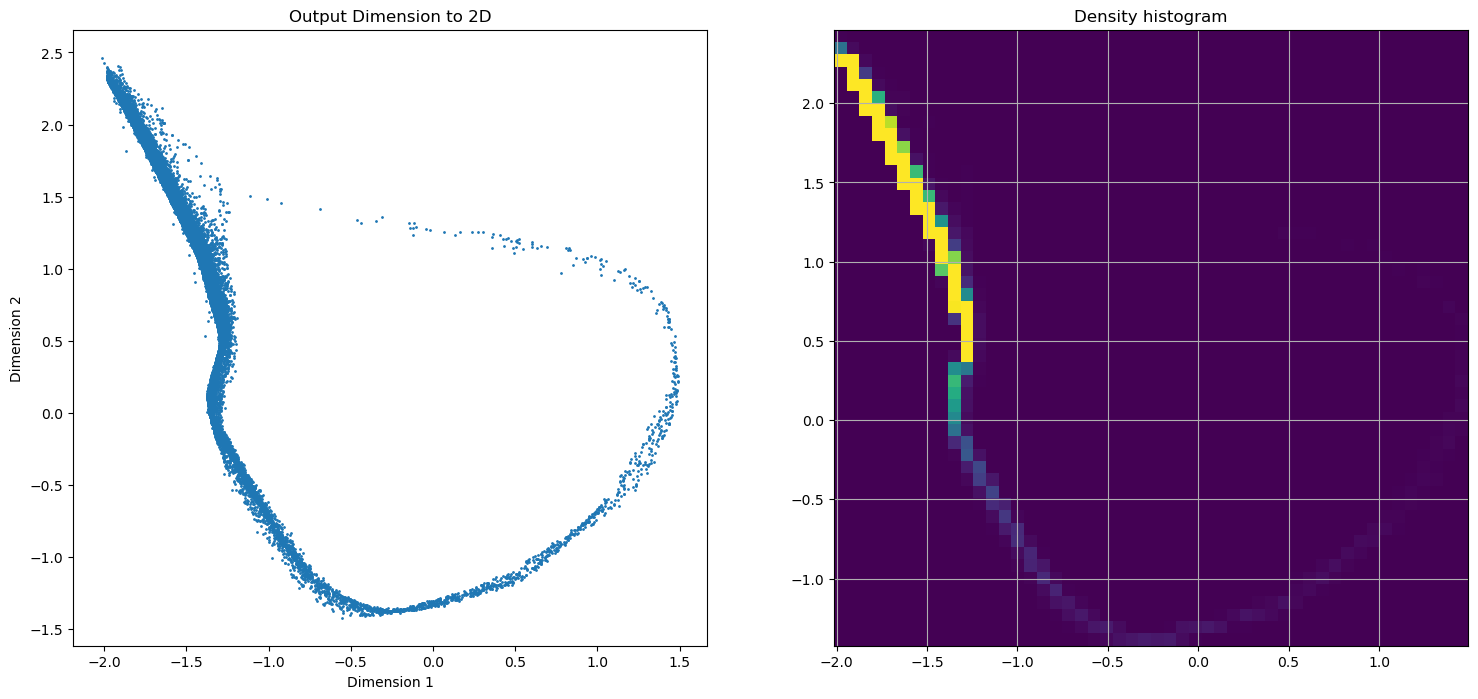

In [86]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
scatter = plt.scatter(stacked_outputs[:, 0], stacked_outputs[:, 1], cmap='Spectral', s=1)
plt.title('Output Dimension to 2D')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.subplot(122)
plt.hist2d(stacked_outputs[:, 0], stacked_outputs[:, 1], bins=50, vmax=690)
plt.grid(True)
plt.title('Density histogram')
plt.show()

Text(0.5, 1.0, 'Density histogram')

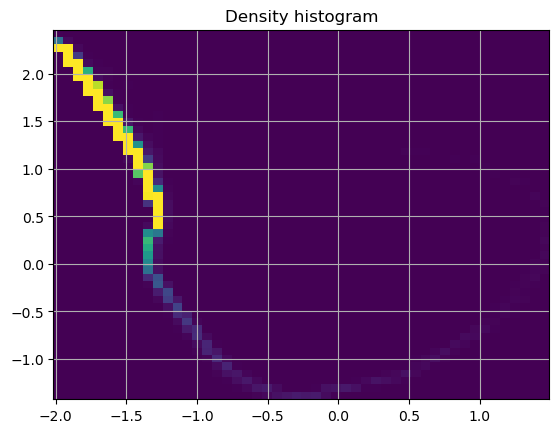

In [92]:
plt.hist2d(stacked_outputs[:, 0], stacked_outputs[:, 1], bins=50, vmax=690)
plt.grid(True)
plt.title('Density histogram')

In [44]:
mapper2D = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42).fit(stacked_outputs)

KeyboardInterrupt: 

No cosine distance supported by HDBscan: L2 normalize and euclidian distance.

In [45]:
embedding_L2 = stacked_outputs / np.linalg.norm(stacked_outputs, ord=2)

In [46]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=15, metric='euclidean')
clusterer.fit(embedding_L2)
labels = clusterer.labels_

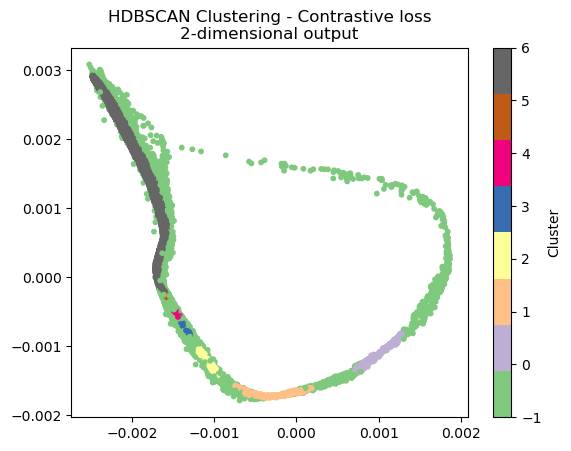

In [75]:
# Full dataset
plt.scatter(embedding_L2[:, 0], embedding_L2[:, 1], c=labels, cmap='Accent', s=10)
plt.colorbar(label='Cluster')
plt.title('HDBSCAN Clustering - Contrastive loss\n2-dimensional output')
plt.show()

In [72]:
from inverse_mapping_functions import WAVELENGTHS_ARRAY

In [73]:
def plot_n_random_spectra_cluster(labels, stacked_outputs, chosen_cluster, dataset, nbr_items=5,
                                  dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train.nc"):
    '''
    Plots nbr_item belonging to a given cluster.
    dataset: SproutDataset object, with augmentation_type set to None.
    '''
    labels_reshaped = labels.reshape(-1, 1)
    print('labels shape: ', labels_reshaped.shape)
    outputs_with_labels = np.hstack((stacked_outputs, labels_reshaped))
    idxes = np.where(outputs_with_labels[:,-1] == chosen_cluster)[0]
    random_spectra_idx = np.random.choice(idxes, size=nbr_items, replace=False)

    for i in random_spectra_idx:
        plt.figure(figsize=[12,4], tight_layout=True)
        item = dataset.__getitem__(i)
        plt.plot(WAVELENGTHS_ARRAY, item[0])
        plt.title(f'Item number #{i}')
        plt.show()

labels shape:  (117120, 1)


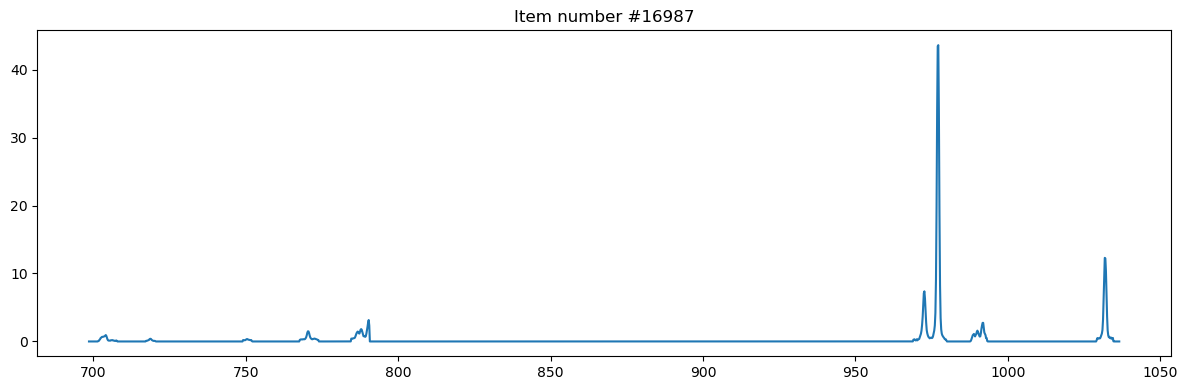

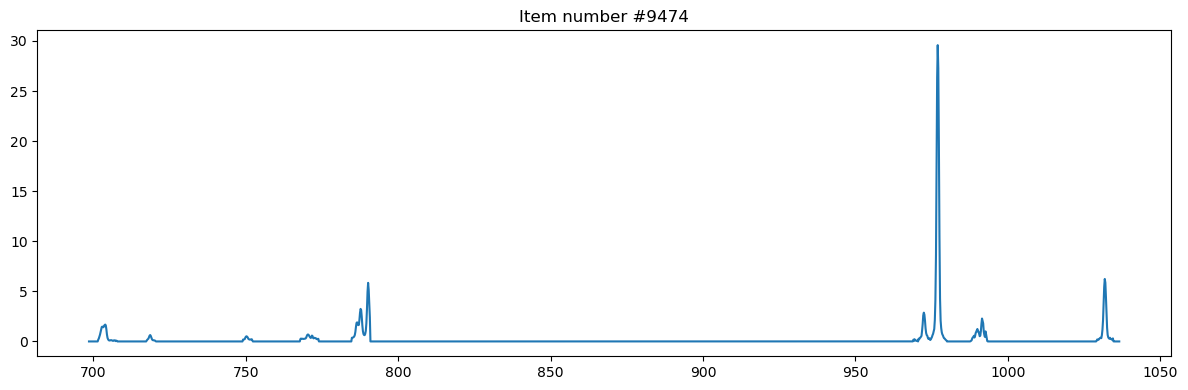

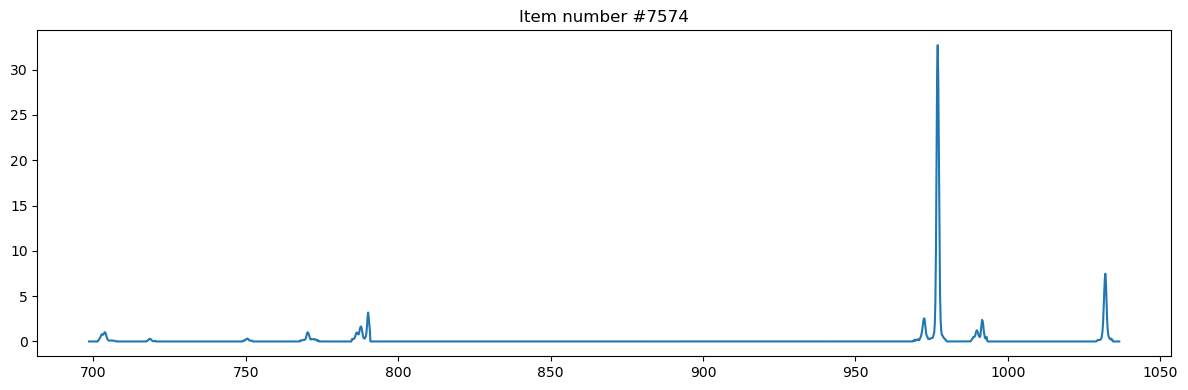

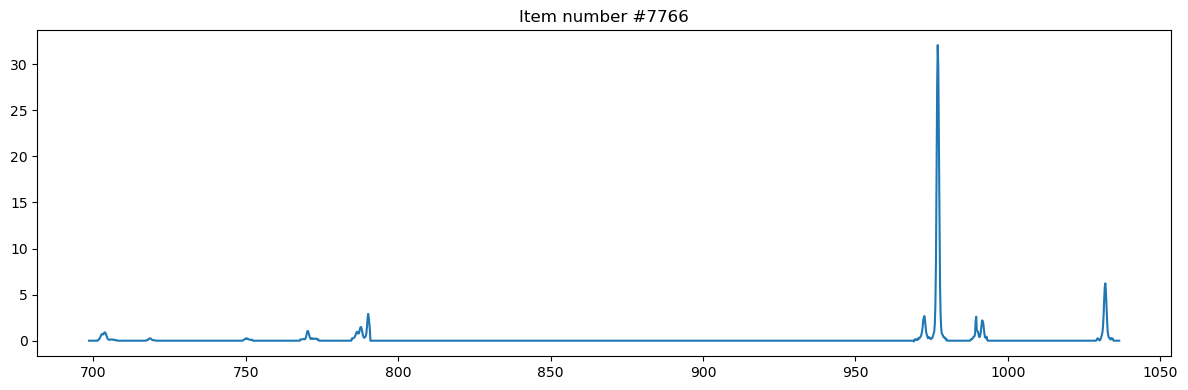

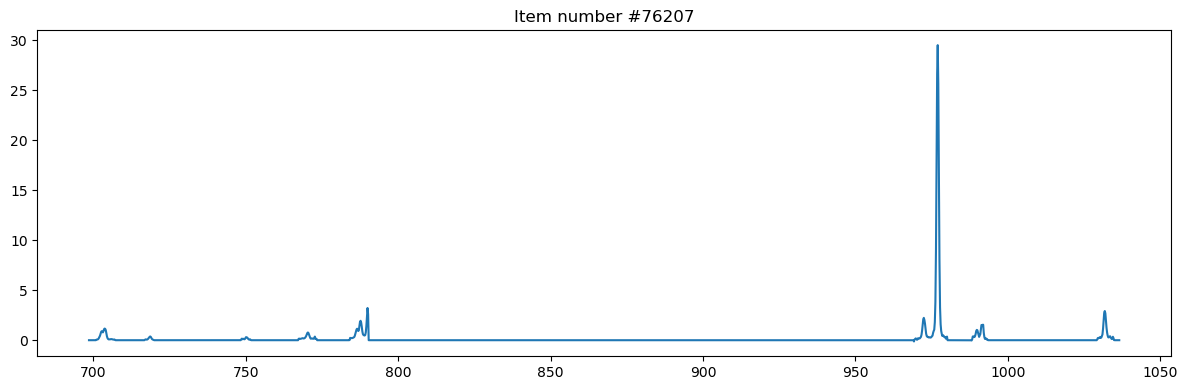

In [74]:
plot_n_random_spectra_cluster(labels, stacked_outputs, 1, dataset_none)

In [49]:
from sunraster.instr.spice import read_spice_l2_fits   
import xarray as xr

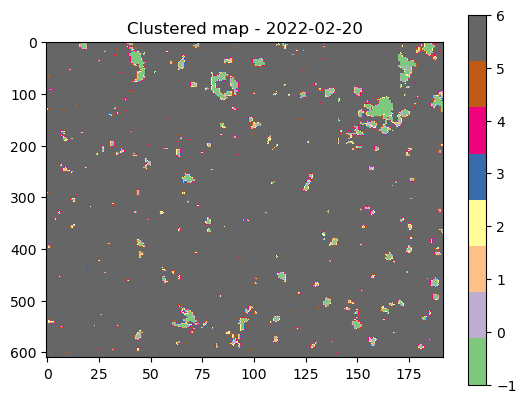

solo_L2_spice-n-ras_20220220T125345_V22_100663594-000.fits
(40, 610, 192)


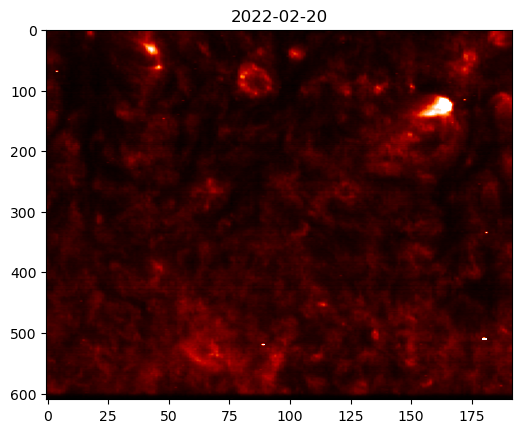

In [ ]:
def map_item_map(item_nbr, dataset, plot=False, data_dir='C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\data_L2\\', key='Ne VIII 770 (Merged)',
                 croplatbottom=725, croplattop=115, title=' '):
    filename = str(dataset.isel(index=item_nbr)['filename'].data)
    print(filename)
    i,j = (dataset.isel(index=item_nbr)['x-index'].data, dataset.isel(index=item_nbr)['y-index'].data)
    exposure = read_spice_l2_fits(data_dir+filename, memmap=False)
    cube = exposure[key][0,:,croplattop:croplatbottom,:].data
    plt.imshow(cube[20, :, :], aspect=1/4, cmap='gist_heat', vmax=np.nanquantile(cube[20, :, :], 0.999))
    print(cube.shape)
    if plot:
        plt.plot(j,i, color='red', marker='+', label=str(item_nbr))
    if title:
        plt.title(title)
        plt.legend()

datasetmini = xr.open_dataset("C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train_mini.nc")
labels_1file = labels.reshape(610,192)

plt.imshow(labels_1file, cmap='Accent', aspect=1/4)
plt.colorbar()
plt.title('Clustered map - 2022-02-20')
plt.show()
map_item_map(80000, datasetmini, title='2022-02-20')